In [3]:
# transformer plus a simple equations: learning some wave rules
import torch
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from wavefn import WaveFunction

batch_size = 8
block_size = 16
max_iter = 5000
epochs = 5
eval_interval = 500
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embed = 64
n_head = 8
n_layer = 8
dropout = 0.2
text = []

# tokens set as integers
tokens = ['F1', 'F2', 'F3', 'F4', '_', 'M', 'H', 'B','s','e']

# Let's make some waves! Not strictly needed, but repurposing the wave fn so keeping it for now
c = 1.0  # Wave speed
dx = 0.1  # Spatial step size
dt = 0.1  # Time step size
wave_fn = WaveFunction(c, dx, dt)

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
def enc(s, pad_length):
    encoded = [stoi[ch] for ch in s if ch in stoi]
    padding = [stoi['_']] * (pad_length - len(encoded))  # Padding token is '_'
    return encoded + padding[:max(0, pad_length - len(encoded))]  # Ensures the sequence is exactly pad_length long
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')
# Define an appropriate size for your validation batch
val_batch_size = batch_size  

def generate_operation_sequence_with_objective(block_size):
    objective = random.choice(['M', 'H', 'B'])
    if objective == 'M':
        sequence = ['F1', 'F4', 'e', '_', '_', '_', '_']
    elif objective == 'H':
        sequence = ['F2', 'F3', 'e', '_', '_', '_', '_']
    else:  # B includes all operations
        sequence = ['F1', 'F2', 'F3', 'F4', 'e', '_', '_']

    # Ensure the sequence length does not exceed block size - 2 for start/end tokens
    sequence = sequence[:block_size - 2]
    return [objective] + sequence

def apply_operations_sequence_to_wave(sequence, initial_wave):
    wave_fn = WaveFunction()
    current_profile = np.array(initial_wave, dtype=int)
    operations_map = {
        'F1': wave_fn.F1, 'F2': wave_fn.F2, 'F3': wave_fn.F3, 'F4': wave_fn.F4,
        '_': lambda x: x  # No-operation function returns the input as is
    }
    
    # Start applying transformations after the objective; skip '_'
    for op in sequence[1:]:  # Skip the 'objective' token
        if op in operations_map:  # Check if operation is defined in the map
            current_profile = operations_map[op](current_profile)
    
    return current_profile

def get_batch(batch_size, block_size):
    sequences = [generate_operation_sequence_with_objective(block_size) for _ in range(batch_size)]
    X, Y = [], []
    for seq in sequences:
        x_encoded = [stoi[ch] for ch in seq]  # All tokens in seq are input
        # Correct target padding to ensure each target matches logits
        y_encoded = [stoi[ch] for ch in seq[1:]] + [stoi['_']] * (8 - len(seq[1:]))  # Pad to T=8, not block_size
        X.append(torch.tensor(x_encoded, dtype=torch.long).to(device))
        Y.append(torch.tensor(y_encoded, dtype=torch.long).to(device))
    X = torch.stack(X)  # Stack all sequences
    Y = torch.stack(Y)  # Stack targets (important change from cat to stack)
    return X, Y.view(-1)  # Flatten Y to match logits

class DynamicAdjustment(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.adjust = nn.Linear(embed_size, 1)

    def forward(self, weights, values):
        adjustment = torch.sigmoid(self.adjust(values))
        return weights * adjustment.expand_as(weights)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)
        self.dynamic_adjustment = DynamicAdjustment(head_size)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        # wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dynamic_adjustment(wei, v)  # Apply dynamic adjustment based on value
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class SinusoidalActivation(nn.Module):
    def forward(self, x):
        # return torch.sin(x)
        return x + torch.sin(x) ** 2

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.GELU(),
            # SinusoidalActivation(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class HierarchicalAttention(nn.Module):
    def __init__(self, num_heads, head_size, levels=3):
        super().__init__()
        self.levels = nn.ModuleList([MultiHeadAttention(num_heads, head_size) for _ in range(levels)])

    def forward(self, x):
        for attention in self.levels:
            x = attention(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        attn_output = self.sa(self.ln1(x))
        x = x + attn_output  # add & norm for attention
        ffwd_output = self.ffwd(self.ln2(x))
        x = x + ffwd_output  # add & norm for feedforward
        return x

# Add a memory module to the model, to help it remember past interactions
class ExternalMemory(nn.Module):
    def __init__(self, memory_size, feature_dim):
        super().__init__()
        self.memory = nn.Parameter(torch.randn(memory_size, feature_dim))

    def read(self, query):
        score = F.softmax(query @ self.memory.t(), dim=-1)
        return score @ self.memory

    def write(self, query, data):
        self.memory.data = data  # Simplest form of memory update for illustration

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size  # Save block_size as an instance variable
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)
        self.memory = ExternalMemory(100, n_embed)  # Example memory size and feature dimension

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape  # Confirm dimensions: B should be 8, T should be 8
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)).unsqueeze(0).expand(B, T, -1)
        memory_read = self.memory.read(tok_emb.mean(dim=1))  # Read from memory based on average token embeddings
        x = tok_emb + pos_emb + memory_read.unsqueeze(1).expand(-1, T, -1)  # Add memory readout to input        
        # x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        logits = logits.view(-1, self.vocab_size)  # Flatten logits

        if targets is not None:
            # print(f'Logits final shape for cross-entropy: {logits.shape}')  # Should be [64, 8]
            # print(f'Targets shape for cross-entropy: {targets.shape}')  # Should also be [64]
            if logits.shape[0] != targets.shape[0]:
                raise ValueError(f"Logits and targets count mismatch: {logits.shape[0]} vs {targets.shape[0]}")
            loss = F.cross_entropy(logits, targets)
            return logits, loss
        return logits, None

    def generate(self, idx, max_new_tokens):
        outputs = idx
        for _ in range(max_new_tokens):
            idx_cond = outputs[:, -block_size:] if outputs.size(1) > block_size else outputs
            logits, _ = self(idx_cond)
            if logits.dim() == 2:
                logits = logits.unsqueeze(1)  # Ensure we have [batch, sequence, features]
            logits = logits[:, -1, :]  # Get the last token's logits for next prediction
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1).squeeze(-1)  # Simplify to [batch, sequence]

            # Debug shapes to ensure correct dimensions
            # print(f'outputs shape: {outputs.shape}')
            # print(f'idx_next shape: {idx_next.shape}')

            # Ensure idx_next matches outputs' batch size
            if idx_next.dim() == 1:
                idx_next = idx_next.unsqueeze(0)  # Correct shape to [1, 1]

            outputs = torch.cat([outputs, idx_next], dim=1)  # Concatenate along sequence dimension
        return outputs

def apply_predicted_operations(predicted_operations, initial_wave):
    wave_fn = WaveFunction()
    current_profile = np.array(initial_wave, dtype=int)
    operations_map = {'F1': wave_fn.F1, 'F2': wave_fn.F2, 'F3': wave_fn.F3, 'F4': wave_fn.F4}
    
    for op in predicted_operations:
        if op in operations_map:
            current_profile = operations_map[op](current_profile)
    
    return current_profile

model = LanguageModel()
m = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.5, centered=False)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        max_norm = 1
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

torch.save(model, 'models/cat_wavefn_model.pth')

Epoch 0, Iteration 0: Training Loss = 2.400118350982666, Validation Loss = 2.2483253479003906
Epoch 0, Iteration 500: Training Loss = 0.07923953980207443, Validation Loss = 0.06724333018064499
Epoch 1, Iteration 0: Training Loss = 0.017654309049248695, Validation Loss = 0.017464401200413704
Epoch 1, Iteration 500: Training Loss = 0.007991906255483627, Validation Loss = 0.007720447611063719
Epoch 2, Iteration 0: Training Loss = 0.004752492066472769, Validation Loss = 0.004462573677301407
Epoch 2, Iteration 500: Training Loss = 0.0030368699226528406, Validation Loss = 0.0030509817879647017
Epoch 3, Iteration 0: Training Loss = 0.002001966815441847, Validation Loss = 0.001830550841987133
Epoch 3, Iteration 500: Training Loss = 0.0012409765040501952, Validation Loss = 0.0012572432169690728
Epoch 4, Iteration 0: Training Loss = 0.000845341244712472, Validation Loss = 0.0009202170767821372
Epoch 4, Iteration 500: Training Loss = 0.0006516123539768159, Validation Loss = 0.0006193830049596727


Initial Wave Profile: [3 9 7 5 1 1 0 8 6 7 0 9 8 2 1 1]
Transformer output is: F2F2F3F2F3F2
Objective wave output is: [1 9 5 3 0 0 0 7 4 5 0 9 7 0 0 0]
Predicted operations are: ['F2', 'F2', 'F3', 'F2', 'F3', 'F2']
Transformed wave is: [0 9 0 0 0 0 0 1 0 0 0 9 1 0 0 0]


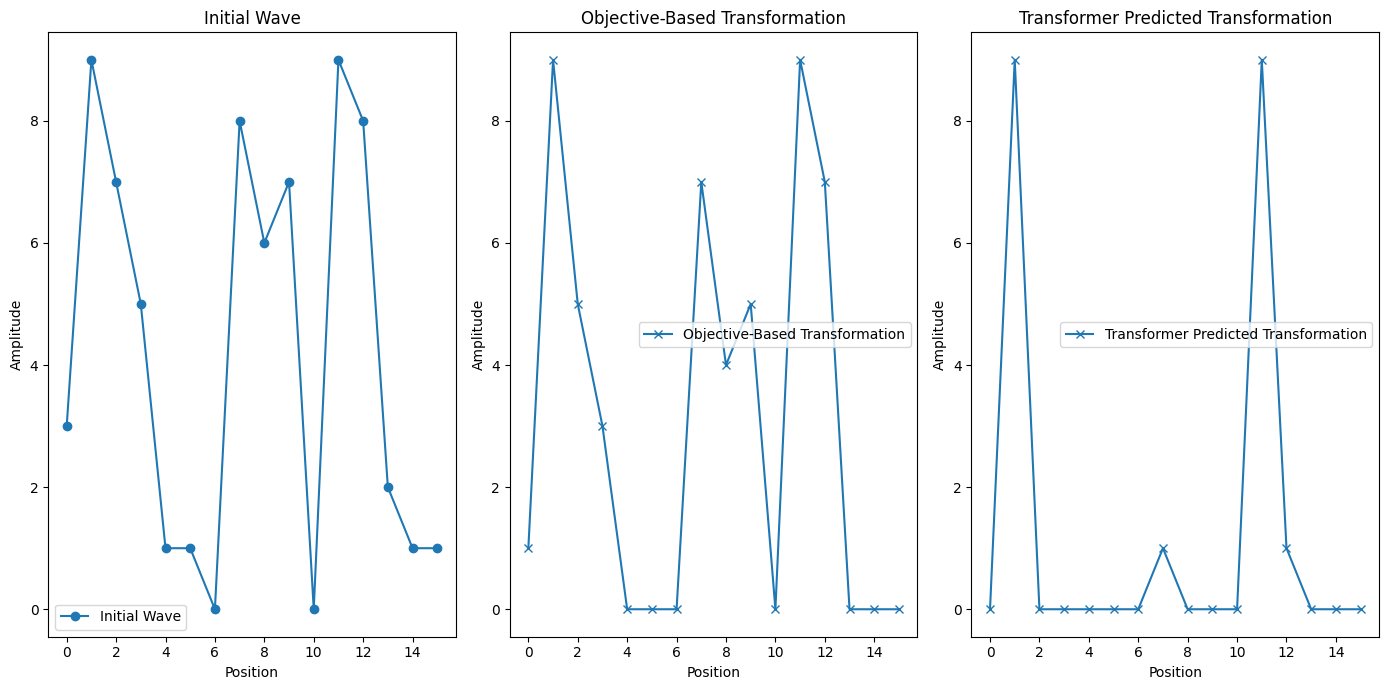

In [4]:
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from wavefn import WaveFunction

# Setting up the environment
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained model and set it to evaluation mode
model = torch.load('models/cat_wavefn_model.pth', map_location=device)
model.eval()
np.random.seed(42)  # Seed for reproducibility
# Initialize the WaveFunction class
wave_fn = WaveFunction()
# Generate a random initial wave profile
input_length = 16
initial_wave = (np.random.rand(input_length) * 10).astype(int)
print(f"Initial Wave Profile: {initial_wave}")

# Prepare the model input
initial_conditions = ['H']
input_tensor = torch.tensor([[stoi[ch] for ch in initial_conditions]], dtype=torch.long).to(device)

# Predict operations
with torch.no_grad():
    output = model.generate(input_tensor, max_new_tokens=3)
    transformer_output = dec(output[0].tolist())

print(f"Transformer output is: {transformer_output}")
def parse_operations(input_string):
    match = re.match(r'(F\d)+', input_string)
    if match:
        # Extract all 'F' followed by a digit from the matched group
        return re.findall(r'F\d', match.group())
    else:
        return []

predicted_operations = parse_operations(transformer_output)

# Compare with direct simulation from WaveFunction using an objective
objective_wave_output = wave_fn.simulate_wave_equation(initial_wave, objective=initial_conditions[0])
print(f"Objective wave output is: {objective_wave_output}")
print(f"Predicted operations are: {predicted_operations}")
transformed_wave = wave_fn.custom_transform(initial_wave, predicted_operations)
print(f"Transformed wave is: {transformed_wave}")

# Plotting results
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.plot(initial_wave, label='Initial Wave', marker='o')
plt.title('Initial Wave')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(objective_wave_output, label='Objective-Based Transformation', marker='x')
plt.title('Objective-Based Transformation')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(transformed_wave, label='Transformer Predicted Transformation', marker='x')
plt.title('Transformer Predicted Transformation')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
